<a href="https://colab.research.google.com/github/SahputraS/Bayesian-SIR-Model/blob/main/MCMC_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import expon, poisson
from scipy.stats import gamma as gamma_stat
from scipy.stats import beta as beta_stat
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import loggamma

In [2]:
N = 1000000
T_max = 100

Delta = np.tile(np.concatenate(([1], np.repeat(0, 24))), 4)
Stage = np.cumsum(Delta)
K = np.sum(Delta)

b = 1 / np.array([0.3, 0.4, 0.25, 0.2])
r = 1 / (1 - np.array([0.05, 0.15, 0.2, 0.25])) - 1

beta = 1 / b[Stage.astype(int)-1]
gamma = r[Stage.astype(int)-1] / (1 + r[Stage.astype(int)-1])

I_current = 50
R_current = 0
S_current = N - I_current - R_current

N_infect_obs = [I_current]
N_recovery_obs = [R_current]

for t in range(1, T_max + 1):
    PI_current = I_current / N
    p_beta = 1 - np.exp(-beta[t - 1] * PI_current)
    New_infect = np.random.binomial(S_current, p_beta, size=1)[0]
    New_recovery = np.random.binomial(I_current, gamma[t - 1], size=1)[0]

    N_infect_obs.append(New_infect)
    N_recovery_obs.append(New_recovery)
    S_current -= New_infect
    I_current -= New_recovery - New_infect
    R_current += New_recovery

S_obs = N - np.cumsum(N_infect_obs)
I_obs = np.cumsum(np.array(N_infect_obs) - np.array(N_recovery_obs))
R_obs = np.cumsum(N_recovery_obs)
PI_obs = I_obs / N
N_infect_obs = N_infect_obs[1:]
N_recovery_obs = N_recovery_obs[1:]

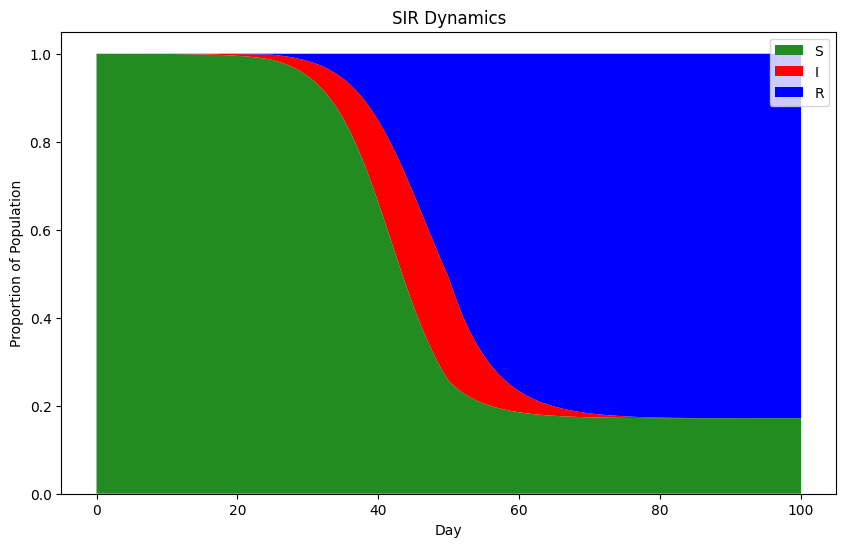

In [3]:
# Plotting
plotting = True
if plotting == True:
  days = np.arange(T_max + 1)
  plt.figure(figsize=(10, 6))
  plt.stackplot(days, S_obs/N, I_obs/N, R_obs/N, labels=['S', 'I', 'R'], colors=['forestgreen', 'red', 'blue'])
  plt.title('SIR Dynamics')
  plt.xlabel('Day')
  plt.ylabel('Proportion of Population')
  plt.legend(loc='upper right')
  plt.show()

In [4]:
#Parameter for MCMC
'''
we discard the first 5000 iterations as burn-in and
draw one posterior sample for every 10 iterations in the next 10000 iterations, leading to G=1000 posterior
samples  in total.
'''
Burnin = 5000
AAA = 1000 #Posterior Sample
thining = 10

In [5]:
# Hyperparameters
T_max = 100
p_a = 1 / T_max**4  ## WHY??
p_b = 2 - p_a  ## WHY??

# Param b
b_shape = 0.1
b_rate = 0.1
gamma_b_shape = math.gamma(b_shape)

# Param r
r_shape = 0.1
r_rate = 0.1
gamma_r_shape = math.gamma(r_shape)


Delta_hat = np.zeros(T_max)
Delta_hat[0] = 1
Stage_hat = np.cumsum(Delta_hat)
K_hat = int(np.max(Stage_hat))

b_hat = np.zeros(K_hat)
r_hat = np.zeros(K_hat)

beta_hat = np.zeros(T_max)
gamma_hat = np.zeros(T_max)
contact_hat = np.zeros(T_max)

# Generating b_hat and r_hat values
for i in range(K_hat):
    b_hat[i] = gamma_stat.rvs(b_shape, scale=1/b_rate)
    r_hat[i] = gamma_stat.rvs(r_shape, scale=1/r_rate)

In [6]:
beta_hat = np.zeros(T_max)
gamma_hat = np.zeros(T_max)
contact_hat = np.zeros(T_max)

for t in range(T_max):
    stage_index = int(Stage_hat[t] - 1)  # Adjusted for zero-indexing

    # Initial estimates
    beta_hat[t] = expon.rvs(scale=1 / b_hat[stage_index])
    gamma_hat[t] = beta_stat.rvs(r_hat[stage_index], 1)

    lambda_t = beta_hat[t] * PI_obs[t]
    p_upper = 1 - poisson.cdf(0, lambda_t)
    pp = np.random.uniform(size=N_infect_obs[t]) * p_upper + (1 - p_upper)
    # Initial contact estimates
    contact_hat[t] = np.sum(poisson.ppf(pp, lambda_t))

    # Recalculate beta and gamma based on contact
    beta_hat[t] = gamma_stat.rvs(contact_hat[t] + 1, scale=1 / (b_hat[stage_index] + PI_obs[t] * S_obs[t]))
    gamma_hat[t] = beta_stat.rvs(N_recovery_obs[t] + r_hat[stage_index], 1 + I_obs[t] - N_recovery_obs[t])

    # Refining the contact estimates
    lambda_t = beta_hat[t] * PI_obs[t]
    p_upper = 1 - poisson.cdf(0, lambda_t)
    pp = np.random.uniform(size=N_infect_obs[t]) * p_upper + (1 - p_upper)
    contact_hat[t] = np.sum(poisson.ppf(pp, lambda_t))

# Output results
print("Beta estimates:", beta_hat)
print("Gamma estimates:", gamma_hat)
print("Contact estimates:", contact_hat)

Beta estimates: [ 0.1879439   0.36354204  0.43587513  0.29989074  0.32970473  0.24415046
  0.32860276  0.25936977  0.3040693   0.32028902  0.2449528   0.256748
  0.24750057  0.28178716  0.26218168  0.29707956  0.29613887  0.31316964
  0.29040244  0.31967441  0.30773821  0.38027979  0.39347261  0.40794262
  0.31758214  0.43374473  0.47868547  0.43021417  0.64794747  0.43979548
  0.89838481  1.05029972  0.62594435  0.83711489  0.63516544  2.25203321
  2.97461343  1.65020668  3.60961092  3.70292585  4.23685334  0.7085524
  1.03451273  2.73193768  0.92906068  5.3326945   1.98693265  0.7570413
  6.56996144 10.92591718  1.8027184   0.92000817  1.7231168   0.66798575
  2.6413272   0.48472131  0.36713549  0.65178397  0.95157695  1.24470209
  1.1778573   0.35262971  0.29760019  0.35705965  0.3789684   0.25432576
  0.31720381  0.5003692   0.28388427  0.33982366  0.26371796  0.24843557
  0.2493994   0.24419221  0.25244774  0.22394067  0.23747266  0.23364474
  0.21556358  0.19111317  0.18249105  0

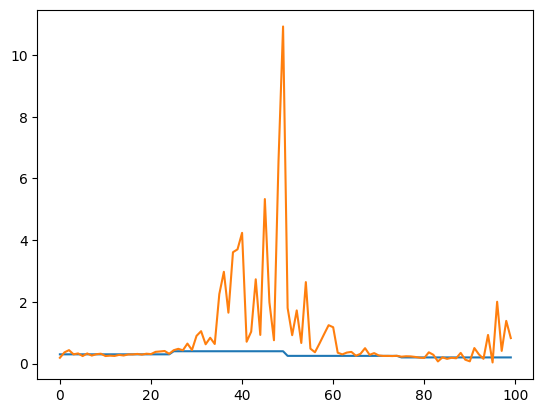

In [7]:
plt.plot(beta)
plt.plot(beta_hat)

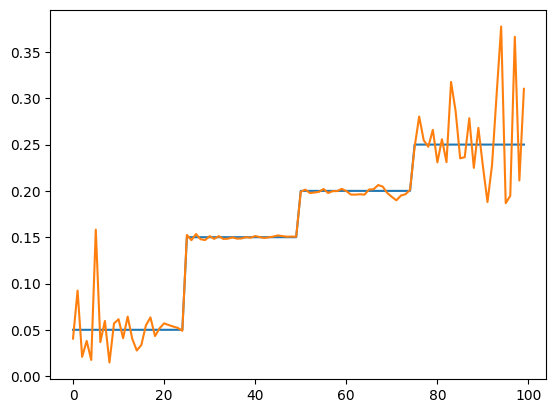

In [8]:
plt.plot(gamma)
plt.plot(gamma_hat)

**update delta**

In [9]:
def candidate_delta(Delta_hat, K_hat, T_max=100):
    change_type = 1 if K_hat == 1 else (-1 if K_hat == T_max else np.random.choice([-1, 0, 1]))
    Delta_hat_candidate = Delta_hat.copy()

    if change_type != 0:
        possible_change_indices = np.where(Delta_hat[1:] != Delta_hat[:-1])[0] + 1
        index_to_change = np.random.choice(possible_change_indices)
        Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
    else:
        possible_swap_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0] + 1
        index_to_swap = np.random.choice(possible_swap_indices)
        Delta_hat_candidate[index_to_swap:index_to_swap+2] = Delta_hat_candidate[index_to_swap+1:index_to_swap-1:-1]

    Stage_hat_candidate = np.cumsum(Delta_hat_candidate) - 1
    K_hat_candidate = np.sum(Delta_hat_candidate)

    return Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate

to get a clear idea i make some functions separately. so have to finish the log likelihood function.

In [10]:
def calculate_log_prior_ratio(K_hat_candidate, K_hat, p=0.01):
    return (K_hat_candidate - K_hat) * np.log(p / (1 - p))

In [11]:
def calculate_log_jump_ratio(K_hat_candidate, K_hat, T_max=100):
    if K_hat == K_hat_candidate:
        return 0
    elif ([K_hat_candidate, K_hat] == [1, 2] or [K_hat_candidate, K_hat] == [T_max, T_max-1]):
        return np.log(3 / (T_max - 1))
    elif ([K_hat_candidate, K_hat] == [2, 1] or [K_hat_candidate, K_hat] == [T_max-1, T_max]):
        return np.log((T_max - 1) / 3)
    elif (K_hat_candidate - K_hat) == -1 and K_hat_candidate != 1 and K_hat_candidate != (T_max-1):
        return np.log((K_hat - 1) / (T_max - K_hat_candidate))
    elif K_hat_candidate - K_hat == 1 and K_hat_candidate != 2 and K_hat_candidate != T_max:
        return np.log((T_max - K_hat) / (K_hat_candidate - 1))

In [12]:
def ll_beta_gamma(delta, beta, gamma):
  K = np.sum(delta)
  eta = np.cumsum(delta)

  n_k = np.array([np.sum(eta == k) for k in range(K)])
  gamma_k = -np.log(pd.Series(gamma).unique())*n_k
  beta_k = pd.Series(beta).unique()*n_k

  logA = (0.2*np.log(0.1)-2*loggamma(0.1))*K
  logB = np.sum(np.log(gamma))
  logC = np.sum(loggamma(0.1+n_k)-(0.1+n_k)*np.log(0.1+beta_k))
  logD = np.sum(loggamma(0.1+n_k)-(0.1+n_k)*np.log(0.1+gamma_k))

  return logA+logB+logC+logD

In [13]:
def calculate_log_likelihood_ratio(Delta_hat, Delta_hat_candidate, beta_hat, gamma_hat):
  ratio = ll_beta_gamma(Delta_hat_candidate, beta_hat, gamma_hat) - ll_beta_gamma(Delta_hat, beta_hat, gamma_hat)
  return ratio

In [14]:
def metropolis_hastings_ratio(log_prior_ratio, log_likelihood_ratio, log_jump_ratio):
    log_mMH = log_prior_ratio + log_likelihood_ratio + log_jump_ratio
    return np.exp(min(0, log_mMH))

In [15]:
def sample_delta(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat,
                 p=0.01, b_shape=0.1, b_rate=0.1, r_shape=0.1, r_rate=0.1, T_max=100):

    Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate = candidate_delta(Delta_hat, K_hat, T_max)

    log_prior_ratio = calculate_log_prior_ratio(K_hat_candidate, K_hat, p)
    log_likelihood_ratio = calculate_log_likelihood_ratio(Stage_hat_candidate, Stage_hat, K_hat_candidate, K_hat, beta_hat, gamma_hat, b_shape, b_rate, r_shape, r_rate)
    log_jump_ratio = calculate_log_jump_ratio(K_hat_candidate, K_hat, T_max)

    ratio = metropolis_hastings_ratio(log_prior_ratio, log_likelihood_ratio, log_jump_ratio)

    if np.random.binomial(1, ratio) == 1:
        return Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate
    else:
        return Delta_hat, Stage_hat, K_hat

still have to finish the log_likelihood_ratio function.

In [16]:
def update_b_r (delta_new, beta_old, gamma_old):

  #Calculate new K and new Neta
  K_new = np.sum(delta_new)
  eta_new = np.cumsum(delta_new)

  # Initializing array for new b and r
  b_new = np.zeros(K_new)
  r_new = np.zeros(K_new)

  epsilon = 1e-10  #Additional small number to avoid error of divide by zero

  for k in range(1,K_new+1):
    indicator_eta = (eta_new == k).astype(int)
    shape_param = 0.1 + np.sum(indicator_eta)

    scale_b = 1 / (np.sum(beta_old * indicator_eta) + epsilon)
    scale_r = 1 / (np.sum(-np.log(gamma_old) * indicator_eta) + epsilon)

    b_new[k-1] = gamma_stat.rvs(shape_param, scale=scale_b)
    r_new[k-1] =  gamma_stat.rvs(shape_param, scale=scale_r)

  return b_new, r_new, K_new, eta_new

In [17]:
## Test function
delta_new = [1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0]
beta_old = beta_hat[0:len(delta_new)]
gamma_old = gamma_hat[0:len(delta_new)]
update_b_r(delta_new, beta_old, gamma_old)

(array([2.71185145, 6.0234473 , 7.17285826, 4.56005117, 3.19648693]),
 array([0.16814955, 0.42966473, 0.82422649, 0.17017562, 0.38855393]),
 5,
 array([1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5]))

### -next step after the update delta, beta, gamma, b, and r :
- make loop of MCMC
- aggregate the results of delta
- result evaluation
- plotting